T23

DetectAsana - Classification of Body Postures and movements 

Machine Learning - CSE343, IIIT Delhi - Monsoon 2020

Authors - Bhavey Wadhwa, Ritik Garg, Rohit Makkar


##**Final Pipeline**

PUCRio dataset

1.   Data is already Z-normalized
2.   Train Test Stratified Split ~ 70 : 30 
3.   Feature Extraction ~ Pitch, Norm and Roll extracted for all four accelerometers
4.   Feature Selection ~ Using mRMR
5.   Handling class imbalance by using bagging/Monte Carlo Method
6.   Classification: Using Random Forest Classifier

Evaluation metrics: Precision, Recall, Accuracy and ROC curve




In [55]:
#Basic Import Statements
!pip install pymrmr
import pymrmr
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
import pickle

In [56]:
#READING DATA
data=pd.read_csv('/content/drive/My Drive/ML DataSet/dataset-har-PUC-Rio-ugulino.csv',sep=';')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [57]:
#ALL THE PLAYING WITH DATA IS DONE HERE
# Here the dataset for BMI contains delimiter ',' we need to replace to '.'
new_data = data['body_mass_index'].str.split(',', expand=True)  #split the dataframe using ',' delimiter
new_data[0]=new_data[0].astype(float)  #convert the datatype to float
new_data[1]=new_data[1].astype(float)  
data['body_mass_index']=new_data[0]+new_data[1]*0.1  #add the columns to get the BMI
# The dataset for Height contains ',' instead of '.' so we need to preprocess it as well 
new_data = data['how_tall_in_meters'].str.split(',', expand=True) #taken the data 
new_data[0]=new_data[0].astype(float) #converted it to type float
new_data[1]=new_data[1].astype(float) 
data['how_tall_in_meters']=new_data[0]+new_data[1]*0.01 #final conversion
#Name and gender are dropped
y_gen=data['gender']
data= data.drop('user', axis=1)
data=data.drop('gender',axis=1)
data=data.replace(to_replace='standingup', value=5)
data=data.replace(to_replace='walking', value=3)
data=data.replace(to_replace='sittingdown', value=4)
data=data.replace(to_replace='sitting', value=1)
data=data.replace(to_replace='standing', value=2)
data=data.replace(to_replace='-14420-11-2011 04:50:23.713', value=-144)
data['weight']=data['weight'].astype(float)
data['x1']=data['x1'].astype(float)
data['x2']=data['x2'].astype(float)
data['y1']=data['y1'].astype(float)
data['z1']=data['z1'].astype(float)
data['x3']=data['x3'].astype(float)
data['y3']=data['y3'].astype(float)
data['z3']=data['z3'].astype(float)
data['x4']=data['x4'].astype(float)
data['y4']=data['y4'].astype(float)
data['z4']=data['z4'].astype(float)

**EDA**

In [58]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
print('Dimensions of data', X.shape)
print('No of samples', X.shape[0])
print('No of features', X.shape[1])
print('Class Distributions', np.unique(np.asarray(y),return_counts=True))

Dimensions of data (165633, 16)
No of samples 165633
No of features 16
Class Distributions (array([1, 2, 3, 4, 5]), array([50631, 47370, 43390, 11827, 12415]))


Gender Based Analysis and Visualization of Data

['Woman' 'Man']
[1. 0.]


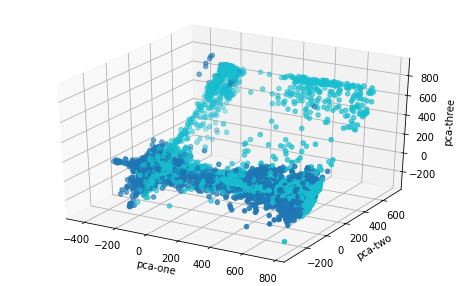

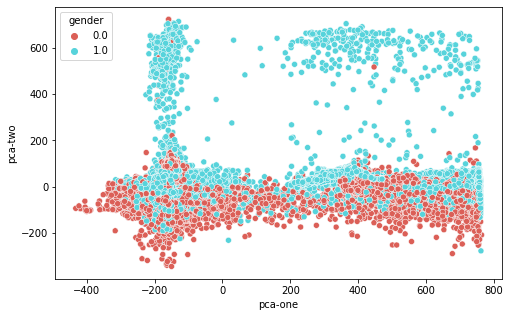

In [59]:
print(y_gen.unique())
y_gen=y_gen.replace(to_replace='Woman', value=1)
y_gen=y_gen.replace(to_replace='Man', value=0)
y_gen=y_gen.astype(float)
print(y_gen.unique())
pca=PCA()
perm=np.random.permutation(X.shape[0])
pca_res=pca.fit_transform(X)
df=pd.DataFrame()
df['pca-one'] = pca_res[:,0]
df['pca-two'] = pca_res[:,1] 
df['pca-three'] = pca_res[:,2]
ax = plt.figure(figsize=(8,5)).gca(projection='3d')
ax.scatter(
    xs=df.loc[perm,:]["pca-one"], 
    ys=df.loc[perm,:]["pca-two"], 
    zs=df.loc[perm,:]["pca-three"], 
    c=y_gen.loc[perm], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue=y_gen.loc[perm],
    palette=sns.color_palette("hls", 2),
    data=df.loc[perm,:]
)
plt.show()

Visualization using PCA and KMeans

Text(0.5, 1.0, 'K-Means clustering')

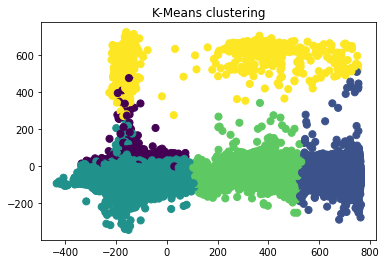

In [60]:
from sklearn.cluster import KMeans
pca=PCA()
x=pca.fit_transform(X)
labels = KMeans(5, random_state=0).fit_predict(x)
plt.scatter(x[:,0],x[:,1], c=labels,
            s=50, cmap='viridis');
plt.title('K-Means clustering')

Text(0.5, 1.0, 'K-Means clustering')

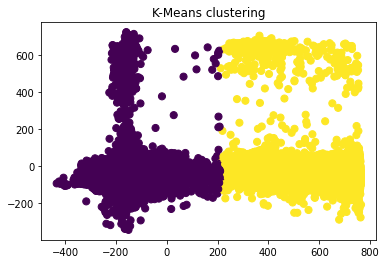

In [61]:
from sklearn.cluster import KMeans
pca=PCA()
x=pca.fit_transform(X)
labels = KMeans(2, random_state=0).fit_predict(x)
plt.scatter(x[:,0],x[:,1], c=labels,
            s=50, cmap='viridis');
plt.title('K-Means clustering')

In [62]:
#Description of the Dataset
X.describe()

,age,how_tall_in_meters,weight,body_mass_index,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4
count,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000
mean,38.265146,1.639712,70.819408,26.188522,-6.649327,88.293667,-93.164611,-87.827504,-52.065047,-175.055200,17.423515,104.517167,-93.881726,-167.641448,-92.625171,-159.650891
std,13.184091,0.052820,11.296527,2.995777,11.616238,23.895829,39.409423,169.435194,205.159763,192.816615,52.635388,54.155843,45.389646,38.311342,19.968610,13.221036
min,28.000000,1.580000,55.000000,22.000000,-306.000000,-271.000000,-603.000000,-494.000000,-517.000000,-617.000000,-499.000000,-506.000000,-613.000000,-702.000000,-526.000000,-537.000000
25%,28.000000,1.580000,55.000000,22.000000,-12.000000,78.000000,-120.000000,-35.000000,-29.000000,-141.000000,9.000000,95.000000,-103.000000,-190.000000,-103.000000,-167.000000
50%,31.000000,1.620000,75.000000,28.400000,-6.000000,94.000000,-98.000000,-9.000000,27.000000,-118.000000,22.000000,107.000000,-90.000000,-168.000000,-91.000000,-160.000000
75%,46.000000,1.710000,83.000000,28.600000,0.000000,101.000000,-64.000000,4.000000,86.000000,-29.000000,34.000000,120.000000,-80.000000,-153.000000,-80.000000,-153.000000
max,75.000000,1.710000,83.000000,28.600000,509.000000,533.000000,411.000000,473.000000,295.000000,122.000000,507.000000,517.000000,410.000000,-13.000000,86.000000,-43.000000


####Feature Extraction

In [63]:
for i in range(1,5):
  x='x'+str(i)
  y='y'+str(i)
  z='z'+str(i)
  norm='norm'+str(i)
  roll='roll'+str(i)
  pitch='pitch'+str(i)
  data[pitch]=np.arctan(data[y]/np.sqrt(data[x]**2+data[z]**2))
  data[norm]=np.sqrt(data[x]**2+data[y]**2+data[z]**2)
  data[roll]=np.arctan(-1*data[x]/data[z])

data=data.sample(frac=1)
cl=['age', 'how_tall_in_meters', 'weight', 'body_mass_index', 'x1', 'y1',
       'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4',
       'pitch1', 'norm1', 'roll1', 'pitch2', 'norm2', 'roll2', 'pitch3',
       'norm3', 'roll3', 'pitch4', 'norm4', 'roll4','class']
data=data.reindex(columns=cl)

####Feature Selection

In [64]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
selected_features=pymrmr.mRMR(X,'MIQ',28)
print(selected_features)

['weight', 'body_mass_index', 'pitch1', 'y3', 'roll4', 'y4', 'pitch2', 'z1', 'z4', 'z2', 'norm1', 'x4', 'y2', 'y1', 'x3', 'z3', 'x2', 'roll1', 'norm4', 'norm2', 'norm3', 'x1', 'roll3', 'pitch4', 'pitch3', 'roll2', 'how_tall_in_meters', 'age']


####Handling Class Imbalance using Bagging / Monte Carlo Method
#####Classification using Random Forest

In [65]:
def RandomForest(X_train,y_train,X_test,y_test,m):
  clf=RandomForestClassifier()
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  if m==10:
    outfile=open('/content/drive/MyDrive/ML DataSet/finalmodel.sav',wb)
    pickle.dump(clf,outfile)
  return classification_report(y_pred,y_test,digits=3,output_dict=True)


if __name__=='__main__':
  m=20
  accuracies=[]
  precision=np.zeros((5,1))
  recall=np.zeros((5,1))
  accuracy=0.0
  weightedp=0.0
  weightedr=0.0
  macrop=0.0
  macror=0.0
  data_X=X[selected_features[:22]]
  classes=[1,2,3,4,5]
  n=min(y[y==1].shape[0],y[y==2].shape[0],y[y==3].shape[0],y[y==4].shape[0],y[y==5].shape[0])
  for iter in range(m):
    Xf=pd.DataFrame(columns=data_X.columns)
    yf=np.array([])
    for i in classes:
      X_new=data_X[y==i]
      y_new=y[y==i]
      samp=X_new.sample(n, replace=True, random_state=42)
      Xf=Xf.append(samp)
      yf=np.append(y_new[:n],yf)
    X_train,X_test,y_train,y_test=train_test_split(Xf,yf,stratify=yf,test_size=0.3)
    report=RandomForest(X_train,y_train,X_test,y_test,iter)
    accuracy+=report['accuracy']
    macrop+=report['macro avg']['precision']
    macror+=report['macro avg']['recall']
    weightedp+=report['weighted avg']['precision']
    weightedr+=report['weighted avg']['recall']
    clas=['1.0','2.0','3.0','4.0','5.0']
    for i in clas:
      ind=int(float(i))
      precision[ind-1]=precision[ind-1]+report[i]['precision']
      recall[ind-1]=recall[ind-1]+report[i]['recall']
  print('recall',recall/m)
  print('precision',precision/m)
  print('accuracy',accuracy/m)
  print('macro recall',macror/m)
  print('macro precision', macrop/m)
  print('weighted precision',weightedp/m)
  print('weighted recall',weightedr/m)

recall [[0.99151709]
 [0.99292507]
 [0.99451997]
 [0.99423974]
 [0.99981662]]
precision [[0.99134758]
 [0.99458862]
 [0.99446208]
 [0.99443376]
 [0.99816812]]
accuracy 0.9946000789132518
macro recall 0.9946036951042971
macro precision 0.9946000302417785
weighted precision 0.9946002703867203
weighted recall 0.9946000789132518
